In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
#stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [3]:
testing_size=500
ns=5
kfold = TimeSeriesSplit(n_splits = ns, test_size = testing_size)

In [4]:
data_aapl = data[data['Ticker']=='aapl']
X = data_aapl.drop(['HighR', 'LowR', 'Ticker','Date', 'State'], axis=1)
y = data_aapl['State']

In [5]:
# Convert to numpy arrays if they aren't already
# This helps avoid DataFrame indexing issues
X = np.asarray(X)
y = np.asarray(y)

# Create TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store results
accuracies = []
fold_num = 1

# Define the DTW distance function
def dtw_distance(x, y):
    return dtw.distance(x, y)

In [6]:
# Perform 5-fold time series cross-validation
for train_index, test_index in tscv.split(X):
    # Extract train and test sets using integer indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Define the KNN classifier with DTW metric
    # Use min(3, len(y_train)) to handle cases with very few samples
    knn = KNeighborsClassifier(n_neighbors=min(3, len(y_train)), metric=dtw_distance)
    
    # Train the classifier
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate and store accuracy
    fold_accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(fold_accuracy)
    
    # Print results for this fold
    print(f"Fold {fold_num}:")
    #print(f"  Train indices: {train_index}")
    #print(f"  Test indices: {test_index}")
    print(f"  Accuracy: {fold_accuracy:.4f}")
    
    # If there's enough data to create a confusion matrix
    if len(np.unique(y_test)) > 1 and len(y_test) > 1:
        cm = confusion_matrix(y_test, y_pred)
        print(f"  Confusion Matrix:\n{cm}")
        try:
            print(f"  Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")
        except:
            print("  Could not generate classification report for this fold")
    else:
        print("  Insufficient classes in test set for detailed metrics")
    
    print("-" * 50)
    fold_num += 1

Fold 1:
  Accuracy: 0.8630
  Confusion Matrix:
[[504  52]
 [ 81 334]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       556
           1       0.87      0.80      0.83       415

    accuracy                           0.86       971
   macro avg       0.86      0.86      0.86       971
weighted avg       0.86      0.86      0.86       971

--------------------------------------------------
Fold 2:
  Accuracy: 0.8496
  Confusion Matrix:
[[190  24]
 [122 635]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.89      0.72       214
           1       0.96      0.84      0.90       757

    accuracy                           0.85       971
   macro avg       0.79      0.86      0.81       971
weighted avg       0.89      0.85      0.86       971

--------------------------------------------------
Fold 3:
  Accuracy: 0.9279
  Confusion Matrix:
[[ 96  

Average Accuracy: 0.8958 ± 0.0328


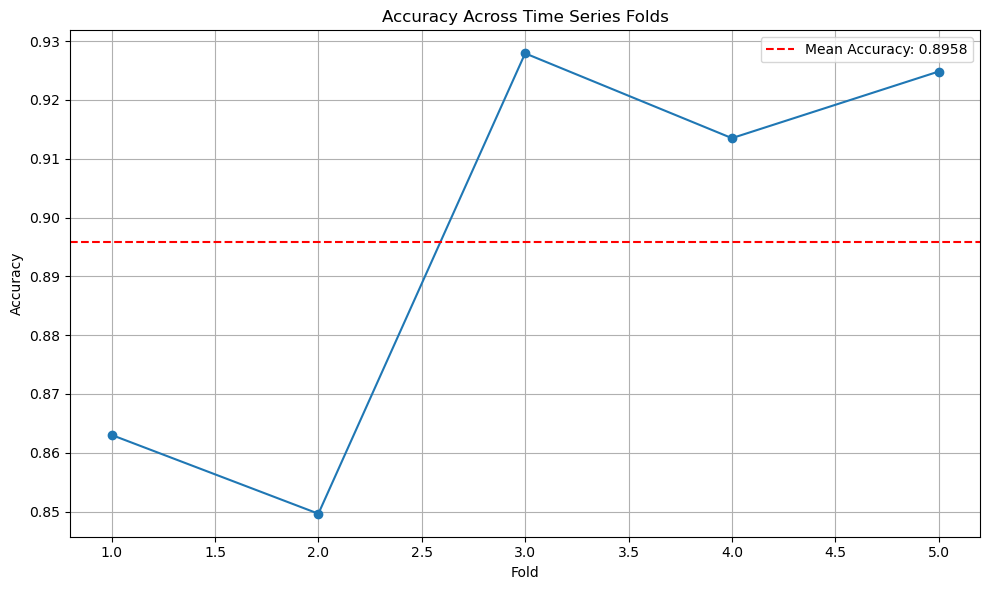

In [7]:
# Calculate and print average accuracy
if accuracies:
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    print(f"Average Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    # Visualize accuracies across folds
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
    plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Time Series Folds')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy metrics were calculated.")

### Sliding window implementation

In [8]:
#load training, test windows here, they're saved for complexity reasons, run code from here
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [ ]:
#model = KNeighborsClassifier(n_neighbors=3, metric=dtw_distance)
model = KNeighborsClassifier()
accuracies_knn = {}
for window in training_lists.keys():
    training_list = training_lists[window]
    testing_list = testing_lists[window]
    a=0 
    for i in range(ns):
        model.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies_knn[window] = a

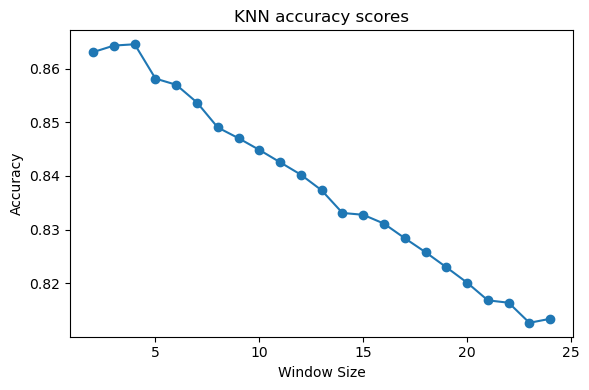

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(list(accuracies_knn.keys()), list(accuracies_knn.values()), marker='o')
plt.title("KNN accuracy scores")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

### End